
# NILM Short‑Burst Sparsity Analyzer
Use this notebook to understand **when** and **why** an appliance (kettle, microwave, etc.) is sparse in your dataset:
- Visualize **rolling ON‑rate** over time
- Check **ON‑rate by time bins**
- Detect **episodes** and their duration/spacing distributions
- See **hour‑of‑day / day‑of‑week** activity
- Sweep **split boundaries** to find barren regions
- Auto‑suggest **pos_weight** and **sampling knobs**

> **How to run:** Update the `CONFIG` cell below (CSV path and appliance column), then Run All.


In [1]:

# =========================
# CONFIG — EDIT THESE
# =========================
CONFIG = {
    # Path to your REFIT-style house CSV with columns: Time, Aggregate, <appliance>
    "csv_path": r"C:\\Users\\rcper\\OneDrive\\Desktop\\Research\\Research(2025)\\DSM_and_NILM\\SGN_NILM\\CLEAN_REFIT_081116\\CLEAN_House2.csv",
    "appliance_col": "Appliance8",   # e.g., "Appliance2" or "kettle" column name
    "resample_rule": "30s",          # match your training pipeline (e.g., "30s" or "1min")
    "max_rows": 3000000,                # or an int to limit rows during exploration

    # Labeling / window params (match training)
    "win_len": 128,
    "on_threshold": 40.0,
    "off_threshold": 15.0,
    "min_hold": 1,

    # Rolling analytics
    "rolling_window_centers": 20000,  # length in *centers* for rolling ON-rate plot
    "bins_for_on_rate": 10,           # decile breakdown across time

    # Edge dilation (+/- w centers around transitions) to count "edges"
    "edge_dilate": 3,

    # Split sweep (simulate different time split boundaries)
    "split_grid_points": 21,          # number of boundaries between 0.6..0.99 to test
    "split_min": 0.60,
    "split_max": 0.99
}
print("Loaded CONFIG. Edit paths/columns as needed and re-run.")


Loaded CONFIG. Edit paths/columns as needed and re-run.


In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# ---- Labeler (same logic as your dataset.py) ----
def make_onoff_labels(target_watts, on_threshold=20.0, off_threshold=10.0, min_hold=1):
    on = np.zeros_like(target_watts, dtype=np.uint8)
    state, hold = 0, 0
    for i, p in enumerate(target_watts):
        if state == 0:
            if p >= on_threshold:
                state, hold = 1, min_hold
        else:
            if p <= off_threshold and hold <= 0:
                state = 0
            else:
                hold -= 1
        on[i] = state
    return on

def centers_for_win_len(T, win_len):
    half = win_len // 2
    return np.arange(half, T - (win_len - half) + 1)

def rolling_on_rate(series01, window):
    # series01 is 0/1 numpy array
    if len(series01) == 0:
        return np.array([])
    w = int(max(1, window))
    pad = w // 2
    x = np.pad(series01.astype(np.float32), (pad, pad), mode='edge')
    cs = np.cumsum(x)
    return (cs[w:] - cs[:-w]) / float(w)

def on_rate_by_bins(series01, bins=10):
    L = len(series01)
    if L == 0: return []
    seg = L // bins
    rates = []
    for b in range(bins):
        s = b*seg
        e = (b+1)*seg if b < bins-1 else L
        if e > s:
            rates.append(float(series01[s:e].mean()))
        else:
            rates.append(0.0)
    return rates

def detect_episodes(onoff):
    # Return start/end indices (inclusive start, exclusive end) where onoff==1
    starts, ends = [], []
    prev = 0
    for i, v in enumerate(onoff):
        if v == 1 and prev == 0:
            starts.append(i)
        if v == 0 and prev == 1:
            ends.append(i)
        prev = v
    if prev == 1:
        ends.append(len(onoff))
    return np.array(starts, dtype=int), np.array(ends, dtype=int)

def episodes_to_df(starts, ends, index):
    # index is DatetimeIndex aligned with samples (NOT centers)
    # durations in samples and minutes (assuming uniform spacing)
    if len(starts) == 0:
        return pd.DataFrame(columns=["start_idx","end_idx","duration_samples","start_time","end_time","duration_minutes"])
    dt = (index[1] - index[0]).total_seconds() / 60.0  # minutes per sample
    durs = (ends - starts).astype(int)
    df = pd.DataFrame({
        "start_idx": starts,
        "end_idx": ends,
        "duration_samples": durs,
        "start_time": index[starts],
        "end_time": index[np.clip(ends-1, 0, len(index)-1)],
        "duration_minutes": durs * dt
    })
    return df

def dilate_edges(change_mask_bool, width=3):
    if width <= 0:
        return change_mask_bool
    edge = change_mask_bool.astype(np.uint8)
    kernel = np.ones(2*width + 1, dtype=np.uint8)
    conv = np.convolve(edge, kernel, mode='same') > 0
    return conv

def hour_day_matrix(event_starts_index):
    if len(event_starts_index) == 0:
        mat = np.zeros((7,24), dtype=int)
        return mat
    # Count episode starts by (day_of_week, hour)
    dow = event_starts_index.dayofweek.values  # 0=Mon..6=Sun
    hour = event_starts_index.hour.values
    mat = np.zeros((7,24), dtype=int)
    for d, h in zip(dow, hour):
        mat[int(d), int(h)] += 1
    return mat

def suggest_pos_weight(on_rate, cap=100.0):
    p = max(on_rate, 1e-9)
    val = (1.0 - p) / p
    return float(min(val, cap))

def fmt_pct(x):
    return f"{100.0*x:.3f}%"


In [3]:

# ---- Load CSV and resample ----
cfg = CONFIG
df = pd.read_csv(cfg["csv_path"], low_memory=False)
assert "Time" in df.columns, "CSV must have a 'Time' column"
assert "Aggregate" in df.columns, "CSV must have an 'Aggregate' column"
assert cfg["appliance_col"] in df.columns, f"CSV missing appliance column: {cfg['appliance_col']}"

df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.dropna(subset=["Time"]).set_index("Time").sort_index()
df = df[["Aggregate", cfg["appliance_col"]]].astype("float32")

# Resample then optionally truncate
df = df.resample(cfg["resample_rule"]).mean().fillna(0.0)
if cfg["max_rows"] is not None:
    df = df.iloc[: cfg["max_rows"]]

print("Data loaded:", df.shape)
df.head()


Data loaded: (1778156, 2)


,Aggregate,Appliance8
Time,,
2013-09-17 22:08:00,694.333313,0.0
2013-09-17 22:08:30,700.000000,0.0
2013-09-17 22:09:00,698.500000,0.0
2013-09-17 22:09:30,579.250000,0.0
2013-09-17 22:10:00,812.500000,0.0


In [4]:

# ---- Prepare arrays & scaling (match training stats shape) ----
mains = df["Aggregate"].values.copy().astype("float32")
target = df[cfg["appliance_col"]].values.copy().astype("float32")

mains_mean = float(np.mean(mains))
mains_std  = float(np.std(mains) + 1e-6)
target_scale = float(np.percentile(np.abs(target), 99))

# Normalizations used during training
mains_n = (mains - mains_mean) / mains_std
target_n = target / (target_scale + 1e-6)

# Labels (ON/OFF) on *watts*
onoff = make_onoff_labels(
    target_watts=target,
    on_threshold=cfg["on_threshold"],
    off_threshold=cfg["off_threshold"],
    min_hold=cfg["min_hold"]
)

# Centers depend on win_len
centers = centers_for_win_len(len(mains), cfg["win_len"])
on_centers = onoff[centers]

# Transition edges (label flips) and dilated edges
change = np.zeros_like(onoff, dtype=bool)
change[1:]  |= (onoff[1:]  != onoff[:-1])
change[:-1] |= (onoff[:-1] != onoff[1:])
edge_mask = dilate_edges(change, width=cfg["edge_dilate"])
edge_centers = edge_mask[centers]

# Diagnostics
train_like_on_rate = float(on_centers.mean())  # not split yet; this is full-series center on-rate
n_centers = len(centers)
n_on_centers = int(on_centers.sum())
n_edge_centers = int(edge_centers.sum())

print("=== FULL-SERIES CENTER DIAGNOSTICS ===")
print(f"Center on-rate: {fmt_pct(train_like_on_rate)}")
print(f"n_centers={n_centers:,} | n_on_centers={n_on_centers:,} | n_edge_centers={n_edge_centers:,}")
print("target_scale (99th pct abs watts):", target_scale)


=== FULL-SERIES CENTER DIAGNOSTICS ===
Center on-rate: 0.845%
n_centers=1,778,029 | n_on_centers=15,020 | n_edge_centers=40,335
target_scale (99th pct abs watts): 0.0


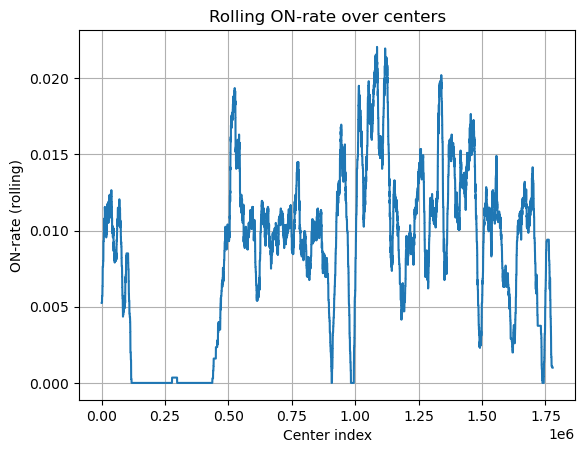

In [5]:

# ---- Rolling ON-rate over centers (reveals barren/rich regions) ----
rates = rolling_on_rate(on_centers.astype(np.float32), window=cfg["rolling_window_centers"])
plt.figure()
plt.plot(rates)
plt.title("Rolling ON-rate over centers")
plt.xlabel("Center index")
plt.ylabel("ON-rate (rolling)")
plt.grid(True)
plt.show()


ON-rate by time decile:
  Decile  1: 0.587%
  Decile  2: 0.004%
  Decile  3: 0.468%
  Decile  4: 1.038%
  Decile  5: 0.973%
  Decile  6: 1.043%
  Decile  7: 1.265%
  Decile  8: 1.263%
  Decile  9: 1.076%
  Decile 10: 0.731%


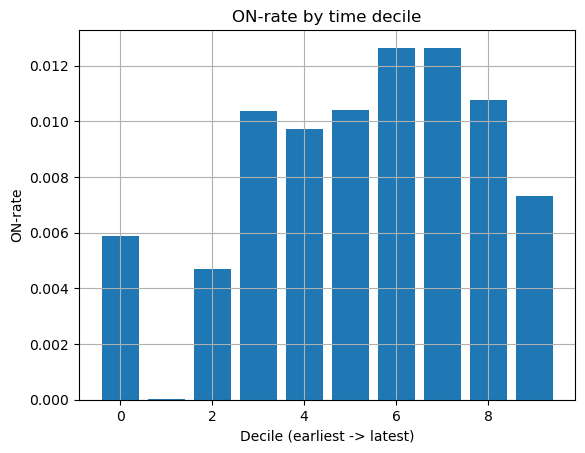

In [6]:

rates10 = on_rate_by_bins(on_centers, bins=cfg["bins_for_on_rate"])
print("ON-rate by time decile:")
for i, r in enumerate(rates10):
    print(f"  Decile {i+1:2d}: {fmt_pct(r)}")

plt.figure()
plt.bar(np.arange(len(rates10)), rates10)
plt.title("ON-rate by time decile")
plt.xlabel("Decile (earliest -> latest)")
plt.ylabel("ON-rate")
plt.grid(True)
plt.show()


In [7]:

starts, ends = detect_episodes(onoff)
episodes = episodes_to_df(starts, ends, df.index)

print(f"Detected episodes: {len(episodes)}")
episodes.head()


Detected episodes: 3465


,start_idx,end_idx,duration_samples,start_time,end_time,duration_minutes
0,984,989,5,2013-09-18 06:20:00,2013-09-18 06:22:00,2.5
1,1740,1747,7,2013-09-18 12:38:00,2013-09-18 12:41:00,3.5
2,1748,1750,2,2013-09-18 12:42:00,2013-09-18 12:42:30,1.0
3,1944,1948,4,2013-09-18 14:20:00,2013-09-18 14:21:30,2.0
4,2140,2146,6,2013-09-18 15:58:00,2013-09-18 16:00:30,3.0


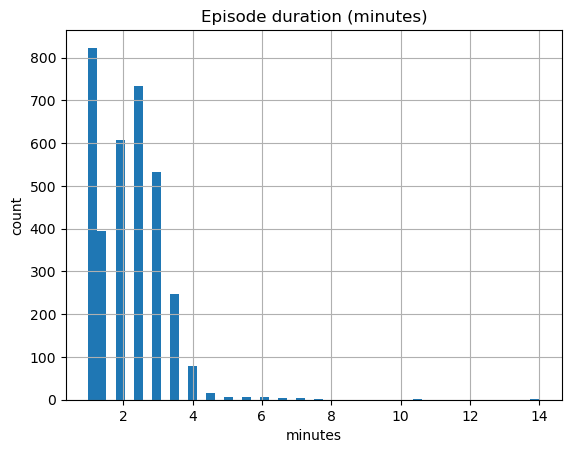

ValueError: Cannot convert from timedelta64[ns] to timedelta64[m]. Supported resolutions are 's', 'ms', 'us', 'ns'

In [8]:

# ---- Duration distribution (minutes) ----
if len(episodes) > 0:
    plt.figure()
    plt.hist(episodes["duration_minutes"].values, bins=50)
    plt.title("Episode duration (minutes)")
    plt.xlabel("minutes")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

    # Inter-event intervals (minutes between starts)
    starts_ts = episodes["start_time"].values
    if len(starts_ts) > 1:
        deltas = (pd.Series(starts_ts[1:]) - pd.Series(starts_ts[:-1])).astype("timedelta64[m]").astype(float)
        plt.figure()
        plt.hist(deltas.values, bins=50)
        plt.title("Inter-event interval (minutes)")
        plt.xlabel("minutes")
        plt.ylabel("count")
        plt.grid(True)
        plt.show()


In [ ]:

# ---- Episode start density by day-of-week and hour-of-day ----
mat = hour_day_matrix(episodes["start_time"]) if len(episodes) > 0 else np.zeros((7,24), dtype=int)
plt.figure()
plt.imshow(mat, aspect='auto', origin='upper')
plt.title("Episode starts: Day-of-week (rows) vs Hour (cols)")
plt.xlabel("Hour of day")
plt.ylabel("Day of week (0=Mon .. 6=Sun)")
plt.colorbar()
plt.show()

# A quick table for the same
hod = episodes["start_time"].dt.hour.value_counts().sort_index() if len(episodes)>0 else pd.Series(dtype=int)
dow = episodes["start_time"].dt.dayofweek.value_counts().sort_index() if len(episodes)>0 else pd.Series(dtype=int)
hod_df = hod.rename("count").to_frame()
dow_df = dow.rename("count").to_frame()
print("Starts by hour-of-day:")
display(hod_df)
print("Starts by day-of-week:")
display(dow_df)


In [ ]:

# ---- Sweep time split boundaries and compute train/val ON-rate ----
# We'll test split points uniformly between split_min..split_max over the centers domain
splits = np.linspace(CONFIG["split_min"], CONFIG["split_max"], CONFIG["split_grid_points"])
train_rates, val_rates = [], []
N = len(centers)
for s in splits:
    cut = int(s * N)
    if cut <= 0 or cut >= N-1:
        train_rates.append(np.nan); val_rates.append(np.nan); continue
    tr = float(on_centers[:cut].mean()) if cut>0 else np.nan
    va = float(on_centers[cut:].mean()) if cut<N else np.nan
    train_rates.append(tr); val_rates.append(va)

plt.figure()
plt.plot(splits, train_rates, label="Train ON-rate")
plt.plot(splits, val_rates, label="Val ON-rate")
plt.title("ON-rate vs split boundary (over centers)")
plt.xlabel("Split boundary as fraction of centers timeline")
plt.ylabel("ON-rate")
plt.grid(True)
plt.legend()
plt.show()

# Suggest a split that achieves >= target ON-rate in train (e.g., >=1%)
target_p = 0.01
candidates = [(s, r) for s, r in zip(splits, train_rates) if r is not None and r >= target_p]
if candidates:
    best_s, best_r = candidates[0]
    print(f"Suggestion: choose split ~{best_s:.3f} to get Train ON-rate >= {fmt_pct(target_p)} (actual {fmt_pct(best_r)})")
else:
    print("No split in the tested range achieves the target train ON-rate; widen range or adjust thresholds.")


In [ ]:

# ---- Suggestions based on observed imbalance ----
p_full = float(on_centers.mean())
pos_w = suggest_pos_weight(p_full, cap=100.0)
print("=== SUGGESTED TRAINING KNOBS (based on full-series centers) ===")
print(f"on_rate ≈ {fmt_pct(p_full)} -> pos_weight ≈ {pos_w:.1f} (cap=100)")
print("Consider for short-burst appliances:")
print("  - cls_on_sample_prob = 0.7")
print("  - edge_sample_prob_cls = 0.7 (with edge dilation as above)")
print("  - alpha_off = 0.06..0.10")
print("  - lr = 3e-4")
print("  - win_len = 96..128")


In [ ]:

# ---- Visualize a few detected episodes on the raw series ----
# Draw up to 3 episodes, with padding before/after
pad_minutes = 10
if len(episodes) > 0:
    shown = 0
    for _, row in episodes.iloc[:3].iterrows():
        st = row["start_idx"]
        en = row["end_idx"]
        # convert padding to samples
        dt_minutes = (df.index[1] - df.index[0]).total_seconds() / 60.0
        pad = int(pad_minutes / dt_minutes)
        s = max(0, st - pad)
        e = min(len(df), en + pad)
        seg = df.iloc[s:e]
        plt.figure()
        plt.plot(seg.index, seg["Aggregate"].values, label="Aggregate")
        plt.plot(seg.index, seg[CONFIG["appliance_col"]].values, label=CONFIG["appliance_col"])
        plt.title(f"Episode around {row['start_time']} (±{pad_minutes} min)")
        plt.xlabel("Time")
        plt.ylabel("Watts")
        plt.grid(True)
        plt.legend()
        plt.show()
        shown += 1
        if shown >= 3: break
else:
    print("No episodes detected to visualize.")


In [ ]:

metrics = {
    "center_on_rate": float(on_centers.mean()),
    "n_centers": int(len(centers)),
    "n_on_centers": int(on_centers.sum()),
    "n_edge_centers": int(edge_centers.sum()),
    "pos_weight_suggested": suggest_pos_weight(float(on_centers.mean()), cap=100.0),
    "win_len": int(CONFIG["win_len"]),
    "on_threshold": float(CONFIG["on_threshold"]),
    "off_threshold": float(CONFIG["off_threshold"]),
    "min_hold": int(CONFIG["min_hold"]),
    "edge_dilate": int(CONFIG["edge_dilate"]),
    "resample_rule": str(CONFIG["resample_rule"]),
}
metrics_df = pd.DataFrame([metrics])
out_csv = "/mnt/data/nilm_sparsity_metrics.csv"
metrics_df.to_csv(out_csv, index=False)
out_csv
